In [1]:
import matplotlib.pyplot as plt
from reproject import reproject_interp

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

import sunpy.map
from sunpy.coordinates import Helioprojective, RotatedSunFrame, transform_with_sun_center
from sunpy.net import Fido, attrs as a

import datetime

import aiapy
from aiapy.calibrate import register, update_pointing, normalize_exposure

import warnings
warnings.filterwarnings("ignore")

print(sunpy.__version__)
print(aiapy.__version__)


3.1.0
0.6.0


In [31]:
current_date = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S")

past = datetime.datetime.now()-datetime.timedelta(minutes=2)

past_date = past.strftime("%Y-%m-%dT%H:%M:%S")

print(past_date)
print(current_date)

startt = str(past_date)
endt= str(current_date)

result = Fido.search(a.Time(startt, endt),
                     a.Instrument("aia"), a.Wavelength(94*u.angstrom) )
print(result)

2021-11-01T13:57:00
2021-11-01T13:59:00
Results from 1 Provider:

1 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search

       Start Time       ...             Info            
                        ...                             
----------------------- ... ----------------------------
2021-11-01 13:57:00.000 ... AIA level 1.5 NRT, 1024x1024




Files Downloaded:   0%|                                 | 0/1 [00:00<?, ?file/s]
aia20211101_135700_0094.fits:   0%|                 | 0.00/4.21M [00:00<?, ?B/s]
aia20211101_135700_0094.fits:   0%|          | 100/4.21M [00:00<2:04:27, 564B/s]
aia20211101_135700_0094.fits:   2%|▏       | 71.6k/4.21M [00:00<1:25:40, 805B/s]
aia20211101_135700_0094.fits:  19%|█▋       | 783k/4.21M [00:00<49:39, 1.15kB/s]
aia20211101_135700_0094.fits:  36%|██▉     | 1.53M/4.21M [00:00<27:13, 1.64kB/s]
aia20211101_135700_0094.fits:  61%|████▊   | 2.55M/4.21M [00:00<11:47, 2.35kB/s]
Files Downloaded: 100%|█████████████████████████| 1/1 [00:01<00:00,  1.17s/file]


2021-11-01T13:56:59.122


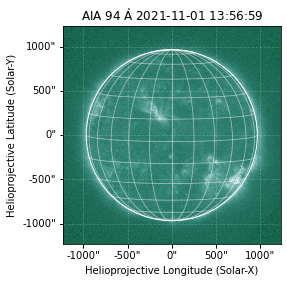

In [32]:
file_download = Fido.fetch(result[0, 0], site='ROB')
aiamap = sunpy.map.Map(file_download[0])
print(aiamap.date)

fig = plt.figure()
ax = fig.add_subplot(111, projection=aiamap)
aiamap.plot()
aiamap.draw_limb()
aiamap.draw_grid()

plt.show()

<RotatedSunHelioprojective Frame (base=<Helioprojective Frame (obstime=2021-11-21T12:00:00.000, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>)>, duration=-19.91876016203704 d, rotation_model=howard)>


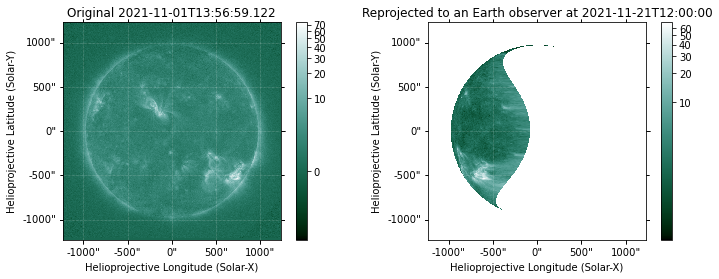


aia20211101_135700_0094.fits: 4.21MB [00:12, 3.35kB/s]                          

In [33]:
in_time = aiamap.date
out_time = '2021-11-21T12:00:00'
out_frame = Helioprojective(observer='earth', obstime=out_time, rsun=aiamap.coordinate_frame.rsun)
rot_frame = RotatedSunFrame(base=out_frame, rotated_time=in_time)
print(rot_frame)

out_shape = aiamap.data.shape
out_center = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=out_frame)
header = sunpy.map.make_fitswcs_header(out_shape,
                                       out_center,
                                       scale=u.Quantity(aiamap.scale))
out_wcs = WCS(header)
out_wcs.coordinate_frame = rot_frame

with transform_with_sun_center():
    arr, _ = reproject_interp(aiamap, out_wcs, out_shape)
    
out_warp = sunpy.map.Map(arr, out_wcs)
out_warp.plot_settings = aiamap.plot_settings

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 2, 1, projection=aiamap)
aiamap.plot( title=f'Original {in_time}')
plt.colorbar()

ax2 = fig.add_subplot(1, 2, 2, projection=out_warp)
out_warp.plot(title=f"Reprojected to an Earth observer at {out_time}")
plt.colorbar()

plt.show()